In [15]:
# Import các thư viện cần thiết
import numpy as np
import cv2
import pandas as pd
import os
import pickle
from google.colab import drive
from google.colab.patches import cv2_imshow

In [16]:
# Connect Google Drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/test_opencv'
# Hiển thị tất cả thư mục hoặc file
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['face.jpg',
 'face2.jpg',
 'models',
 'FaceImage',
 'data_face_features.pickle',
 'ml_face_person_identity.pkl',
 '33.ipynb']

In [17]:
def pipeline_model(path):
    # Face detection model
    faceDetectionModel = '/content/drive/MyDrive/test_opencv/models/res10_300x300_ssd_iter_140000_fp16.caffemodel';

    # Mô tả kiến trúc
    faceDetectionProto = '/content/drive/MyDrive/test_opencv/models/deploy.prototxt.txt'

    # Mô hình mô tả khuôn mặt
    faceDescriptor = '/content/drive/MyDrive/test_opencv/models/openface.nn4.small2.v1.t7'

    # Sử dụng OpenCV DNN đọc mô hìn nhận diện khuôn mặt
    dectectorModel = cv2.dnn.readNetFromCaffe(faceDetectionProto, faceDetectionModel)

    # Đọc mô hình mô tả khuôn mặt từ file Torch
    descriptorModel = cv2.dnn.readNetFromTorch(faceDescriptor)

    # face recognition
    face_recognition_model = pickle.load(open('/content/drive/MyDrive/test_opencv/ml_face_person_identity.pkl',
                                            mode='rb'))
    # pipeline model
    img = cv2.imread(path)
    image = img.copy()
    h,w = img.shape[:2]
    # face detection
    img_blob = cv2.dnn.blobFromImage(img,1,(300,300),(104,177,123),swapRB=False,crop=False)
    # Thiết lập đầu vào cho mô hình
    dectectorModel.setInput(img_blob)
    # Thực hiện việc nhận diện khuôn mặt
    detections = dectectorModel.forward()

    # machcine results
    machinlearning_results = dict(face_detect_score = [],
                                 face_name = [],
                                 face_name_score = [],
                                 count = [])
    count = 1
    if len(detections) > 0:
        for i , confidence in enumerate(detections[0,0,:,2]):
            if confidence > 0.5:
                box = detections[0,0,i,3:7]*np.array([w,h,w,h])
                startx,starty,endx,endy = box.astype(int)

                cv2.rectangle(image,(startx,starty),(endx,endy),(0,255,0))

                # feature extraction
                face_roi = img[starty:endy,startx:endx]
                face_blob = cv2.dnn.blobFromImage(face_roi,1/255,(96,96),(0,0,0),swapRB=True,crop=True)
                descriptorModel.setInput(face_blob)
                vectors = descriptorModel.forward()

                # predict with machine learning
                face_name = face_recognition_model.predict(vectors)[0]
                #face_score = face_recognition_model.predict_proba(vectors).max()
                face_score = 1

                #text_face = '{} : {:.0f} %'.format(face_name,100*face_score)
                text_face = '{}'.format(face_name)
                cv2.putText(image,text_face,(startx,starty),cv2.FONT_HERSHEY_PLAIN,1,(255,255,255),2)

                machinlearning_results['count'].append(count)
                machinlearning_results['face_detect_score'].append(confidence)
                machinlearning_results['face_name'].append(face_name)
                machinlearning_results['face_name_score'].append(face_score)
                count += 1
    return image, machinlearning_results

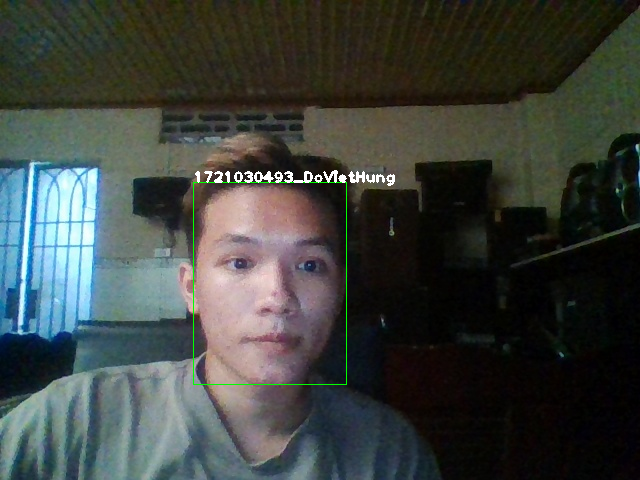

In [18]:
img, results = pipeline_model('/content/drive/MyDrive/test_opencv/FaceImage/1721030493_DoVietHung/image_240.jpg')
cv2_imshow(img)